In [149]:
import json, os, spacy

os.environ['OMP_NUM_THREADS'] = '3'
#parser_path = "/home/ralf/models/en_core_sci_lg-0.5.1/en_core_sci_lg/en_core_sci_lg-0.5.1"
parser_path = "en_core_sci_sm"
parser_path = "en_core_web_trf"
dataset_path = "/home/ralf/IdeaProjects/LitBall-training/EXP-Title+TLDR/"
text_key = "originalTitle"

# Load the spaCy language model:
nlp = spacy.load(parser_path)

ConfigValidationError: 

Config validation error
tagger -> label_smoothing	extra fields not permitted
{'nlp': <spacy.lang.en.English object at 0x7f8ed7059dd0>, 'name': 'tagger', 'label_smoothing': 0.0, 'model': {'@architectures': 'spacy.Tagger.v2', 'nO': None, 'normalize': False, 'tok2vec': {'@architectures': 'spacy-transformers.TransformerListener.v1', 'grad_factor': 1.0, 'upstream': 'transformer', 'pooling': {'@layers': 'reduce_mean.v1'}}}, 'neg_prefix': '!', 'overwrite': False, 'scorer': {'@scorers': 'spacy.tagger_scorer.v1'}, '@factories': 'tagger'}

In [152]:
s = "In-vitro effect of human cathelicidin antimicrobial peptide LL-37 on dengue virus type 2"
nlp(s).text

'In-vitro effect of human cathelicidin antimicrobial peptide LL-37 on dengue virus type 2'

In [99]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import json

In [100]:
#@title

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

In [153]:
import json
dataset_path = "/home/ralf/IdeaProjects/LitBall-training/EXP-Title+TLDR/"
text_key = "preprocessedText"
docs = []
larr1 = []
with open(dataset_path + "ROTVRSV") as file:
    lines = file.readlines()
    for line in lines:
        d = json.loads(line)
        docs.append(d[text_key])
        larr1.append(d["label"])

tdocs = []
larr2 = []
with open(dataset_path + "DENV") as file:
    lines = file.readlines()
    for line in lines:
        d = json.loads(line)
        tdocs.append(d[text_key])
        larr2.append(d["label"])

        # Tokenize the documents.

def tok(s):
    return '_'.join(s.split(' '))

# Get entities from documents.
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = ' '.join([tok(t.text) for t in nlp(docs[idx]).ents])
for idx in range(len(tdocs)):
    tdocs[idx] = tdocs[idx].lower()  # Convert to lowercase.
    tdocs[idx] = ' '.join([tok(t.text) for t in nlp(tdocs[idx]).ents])

print(len(docs))
print(docs[0][:500])
print(len(tdocs))
print(tdocs[0][:500])

22996
carbocisteine inhibit respiratory_syncytial_virus_infection human tracheal_epithelial_cell carbocisteine inhibit virus_infection expression_icam rs_virus_receptor modulate airway inflammation rsirus_infection
8679
vitro effect human cathelicidin dengue_virus_type_2_‐ experiment ‐_silico analysis inhibit dengue_virus_type_2 denv_‐_2 infection_replication_vero_e6_cell bind_e_protein


In [154]:
# Load the dataset
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd

in_memory_file1 = io.StringIO()
for i in range(len(docs)):
    in_memory_file1.write(json.dumps({ text_key: docs[i], "label": larr1[i] }) + '\n')
in_memory_file1.seek(0)
in_memory_file2 = io.StringIO()
for i in range(len(tdocs)):
    in_memory_file2.write(json.dumps({ text_key: tdocs[i], "label": larr2[i] }) + '\n')
in_memory_file2.seek(0)

trds = pd.read_json(in_memory_file1,
                 dtype={text_key: str, "label": str},
                lines=True
                 )
teds = pd.read_json(in_memory_file2,
                 dtype={text_key: str, "label": str},
                lines=True
                 )
tr_ds = tfdf.keras.pd_dataframe_to_tf_dataset(trds, label="label")
te_ds = tfdf.keras.pd_dataframe_to_tf_dataset(teds, label="label")

dataset_path = "/home/ralf/IdeaProjects/LitBall-training/EXP-Title+TLDR/"
with open(dataset_path + "DENV") as file:
    test_lines = file.readlines()
    
print("Made datasets")

Made datasets


In [155]:
def prepare_dataset1(example, label):
    return {"sentence" : tf.strings.split(example[text_key])}, label

def prepare_dataset2(s):
    m = json.loads(s)
    sp = tf.strings.split(m[text_key])
    return m

train_ds = tr_ds.map(prepare_dataset1)
test_ds = te_ds.map(prepare_dataset1)
    
test_cases = list(map(prepare_dataset2, test_lines))

In [156]:
%set_cell_height 300

# Specify the model.
model_1 = tfdf.keras.RandomForestModel(num_trees=300, verbose=2, num_threads=3)

# Train the model.
model_1.fit(x=train_ds, batch_size=None)

<IPython.core.display.Javascript object>

Use /tmp/tmpm08wukpe as temporary training directory


Reading training dataset...
Training tensor examples:
Features: {'sentence': tf.RaggedTensor(values=Tensor("data:0", shape=(None,), dtype=string), row_splits=Tensor("data_1:0", shape=(None,), dtype=int64))}
Label: Tensor("data_2:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'sentence': SemanticTensor(semantic=<Semantic.CATEGORICAL_SET: 4>, tensor=tf.RaggedTensor(values=Tensor("data:0", shape=(None,), dtype=string), row_splits=Tensor("data_1:0", shape=(None,), dtype=int64)))}
Training dataset read in 0:00:00.195249. Found 22996 examples.
Training model...


2023-07-29 17:37:53.610246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [22996]
	 [[{{node Placeholder/_1}}]]
[INFO 23-07-29 17:37:53.8056 CEST kernel.cc:773] Start Yggdrasil model training
[INFO 23-07-29 17:37:53.8056 CEST kernel.cc:774] Collect training examples
[INFO 23-07-29 17:37:53.8056 CEST kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-07-29 17:37:53.8057 CEST kernel.cc:393] Number of batches: 23
[INFO 23-

[INFO 23-07-29 17:45:25.8723 CEST random_forest.cc:802] Training of tree  193/300 (tree index:192) done accuracy:0.807227 logloss:0.603354
[INFO 23-07-29 17:45:39.8886 CEST random_forest.cc:802] Training of tree  199/300 (tree index:198) done accuracy:0.807271 logloss:0.600344
[INFO 23-07-29 17:45:50.1153 CEST random_forest.cc:802] Training of tree  204/300 (tree index:203) done accuracy:0.807097 logloss:0.59895
[INFO 23-07-29 17:46:00.5682 CEST random_forest.cc:802] Training of tree  208/300 (tree index:207) done accuracy:0.807097 logloss:0.598938
[INFO 23-07-29 17:46:10.8322 CEST random_forest.cc:802] Training of tree  213/300 (tree index:212) done accuracy:0.806749 logloss:0.597333
[INFO 23-07-29 17:46:21.8113 CEST random_forest.cc:802] Training of tree  217/300 (tree index:216) done accuracy:0.807271 logloss:0.59591
[INFO 23-07-29 17:46:31.9384 CEST random_forest.cc:802] Training of tree  222/300 (tree index:221) done accuracy:0.807097 logloss:0.595949
[INFO 23-07-29 17:46:43.1688 

Model trained in 0:11:42.902136
Compiling model...


2023-07-29 17:49:36.772385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [22996]
	 [[{{node Placeholder/_1}}]]


Model compiled.


In [157]:
model_1.compile(metrics=["accuracy"])
evaluation = model_1.evaluate(test_ds, batch_size=None)

print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

2023-07-29 17:53:24.965063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [8679]
	 [[{{node Placeholder/_1}}]]


9/9 [==============================] - 1s 129ms/step - loss: 0.0000e+00 - accuracy: 0.8540
BinaryCrossentropyloss: 0.0
Accuracy: 0.8540154099464417


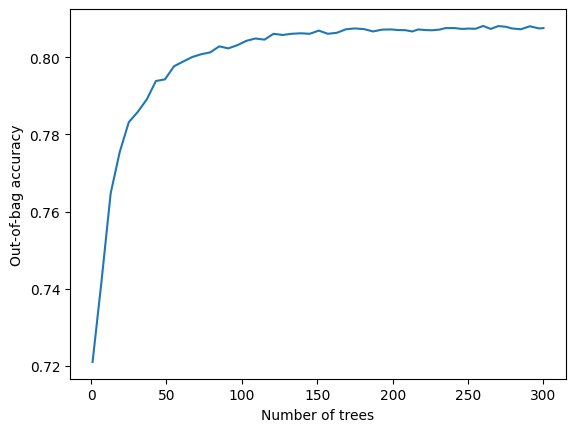

In [158]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag accuracy")
pass

In [159]:
p = model_1.predict(test_ds)

#Fish for best cut
for cut in np.arange(0.25, .8, .05):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    N = len(p)
    for i in range(N):
        tru = test_cases[i]["label"] == '1'
        prd = p[i] > cut
        if tru and prd == tru:
            tp = tp + 1
        if tru and prd != tru:
            fn = fn + 1
        if tru == False and prd == tru:
            tn = tn + 1
        if tru == False and prd != tru:
            fp = fp + 1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    print("cut: {}, acc: {}, prec: {}, rec: {}, f1: {}".format(cut, (tp+tn)/N, precision, recall, f1_score))

9/9 [==============================] - 1s 120ms/step
cut: 0.25, acc: 0.6399354764373776, prec: 0.4147331786542923, rec: 0.9563085153811859, f1: 0.5785569790964261
cut: 0.3, acc: 0.7151745592810231, prec: 0.4741709903000226, rec: 0.937137761925992, f1: 0.6297183942480526
cut: 0.35, acc: 0.7657564235511004, prec: 0.5271037687145069, rec: 0.9103878733838608, f1: 0.667647539643616
cut: 0.39999999999999997, acc: 0.8055075469524139, prec: 0.5822222222222222, rec: 0.8760588497547926, f1: 0.6995372018511924
cut: 0.44999999999999996, acc: 0.8374236663210047, prec: 0.6421736158578264, rec: 0.8377173428444048, f1: 0.727026504159412
cut: 0.49999999999999994, acc: 0.8540154395667704, prec: 0.6882716049382716, rec: 0.7953633526526973, f1: 0.7379524301964839
cut: 0.5499999999999999, acc: 0.8641548565502938, prec: 0.7364444444444445, rec: 0.7387427552385198, f1: 0.7375918094814155
cut: 0.5999999999999999, acc: 0.8641548565502938, prec: 0.7759336099585062, rec: 0.6669638876504681, f1: 0.717333972668424

In [15]:
cut = 55
N = len(p)
with open("/home/ralf//IdeaProjects/LitBall-training/pred.json", "w") as file:
    for c in np.arange(0., .5, .05):
        s = 0
        t = 0
        for i in range(N):
            tru = test_cases[i]["label"] == '1'
            val = int((p[i]+0.005) * 100)
            pred = False
            if val > cut:
                pred = True
            elif val > 100*c:
                s = s+1
                if tru:
                    t = t+1
        print("c: {}, n = {}, tru: {}".format(c, s, t))

c: 0.0, n = 6525, tru: 378
c: 0.05, n = 6396, tru: 378
c: 0.1, n = 5885, tru: 377
c: 0.15000000000000002, n = 4983, tru: 376
c: 0.2, n = 4009, tru: 374
c: 0.25, n = 3139, tru: 368
c: 0.30000000000000004, n = 2379, tru: 351
c: 0.35000000000000003, n = 1765, tru: 323
c: 0.4, n = 1261, tru: 281
c: 0.45, n = 785, tru: 209
